# ETL_EDA

This file includes two parts:  

In the ETL part, it records the process of acquiring raw data, traforming them, and loading them into a MongoDB. The data are store (almost) in their raw form.

In the EDA part, it provides reasonable data analysis for the wildfire alarming and gives the results we come up with after the analysis.

# ETL

In [1]:
import time
import sched
import pandas as pd
from datetime import datetime, timedelta
import json
import logging
import requests
import numpy as np
from io import StringIO

import utils
from database import upsert_dis, upsert_wea

In [2]:
DIS_SOURCE = "https://eonet.sci.gsfc.nasa.gov/api/v2.1/events"
W_SOURCE = "https://api.darksky.net/forecast/b4c50d35d2b602d506c708a505757c25/"
MAX_DOWNLOAD_ATTEMPT = 3
DOWNLOAD_PERIOD = 300        # second
logger = logging.Logger(__name__)
utils.setup_logger(logger, 'data.log')

## 1. Disasters Collection

### a. DataFrame data from DIS

The dataset is a continuously updated DataFrame. It contains the disasters happening/ended in a year. We filtered the data by selecting only three kinds of disasters. It can be retrieved simply by making requests without parameters.

In [3]:
def download_disaster(url=DIS_SOURCE, retries=MAX_DOWNLOAD_ATTEMPT, limit = 10, days = 2, status = "open", timeout = 1.0):
    """Returns disaster information text from `DIS_SOURCE` that includes disaster information
    Returns None if network failed
    """
    js = None
    for _ in range(retries):
        try:
            req = requests.get(f"{url}?limit={limit}&days={days}&status={status}", timeout=timeout)
            req.raise_for_status()
            text = req.text
            js = json.loads(text)
        except requests.exceptions.HTTPError as e:
            logger.warning("Retry on HTTP Error: {}".format(e))
    if js is None:
        logger.error('download_dis too many FAILED attempts')
    return js, status

In [4]:
def filter_dis(js, status):
    """Converts `json` to `DataFrame`
    """
    data = []
    filter_tits = ["Wildfires", "Severe_Storms", "Sea_and_Lake_Ice"]
    for x in js["events"]:
        tit = x["categories"][0]["title"].replace(" ","_")
        if tit not in filter_tits:
            continue
        try:
            id = x["categories"][0]["id"]
            subtit, subid, url = x['title'], x['id'], x['sources'][0]['url'] if x["sources"] else None
            g = x["geometries"]
            for gg in g:
                dt, geo = pd.to_datetime(gg["date"]), gg['coordinates']
                singled = [id, tit, subtit, subid, dt, geo[0], geo[1], status, url]
                data.append(singled)
        except:
            continue
    data = np.array(data)
    df = pd.DataFrame(data, columns = ["id", "title", "subid", "subtitle", "datetime", "geo1", "geo2", "status", "url"])
    return df

### b. upsert Mongodb with DIS

Fetching the data frequently, there are lots of duplicate data entry between each run. The de-duplication happens at insertion. We insert only when the disaster is new else we update it.

In [5]:
def upsert_dis(df):
    """
    Update MongoDB database `disaster` and collection `disasters` with the given `DataFrame`.
    """
    db = client.get_database("disaster")
    collection = db.get_collection("disasters")
    update_count = 0
    for record in df.to_dict('records'):
        result = collection.replace_one(
            filter=record,                              # locate the document if exists
            replacement=record,                         # latest document
            upsert=True)                                # update if exists, insert if not
        if result.matched_count > 0:
            update_count += 1
    logger.info("rows={}, update={}, ".format(df.shape[0], update_count) +
                "insert={}".format(df.shape[0]-update_count))

## 2. Weather Collection

### a. DataFrame data from WEA

In [6]:
def download_weather(url=W_SOURCE, retries=MAX_DOWNLOAD_ATTEMPT, lat=34, lon=-118, timeout=1.0):
    """Returns weather forecast information dataframe from `W_SOURCE` that includes weather information
    Returns None if network failed
    """
    df = None
    for _ in range(retries):
        try:
            req = requests.get(f"{url}{lat},{lon}", timeout=timeout)
            req.raise_for_status()
            text = req.text
            js = json.loads(text)
            data1 = js['daily']['data']

            tstamp = int(datetime.now().timestamp())
            all_data = []
            for ts in range(tstamp, tstamp-86400*30, -86400):
                req = requests.get(f'{url}{lat},{lon},{ts}?exclude=hourly,currently', timeout=3.0)
                req.raise_for_status()
                text = req.text
                js = json.loads(text)
                data = js['daily']['data'][0]
                all_data.append(data)
            data = data1+all_data

            df = pd.DataFrame()
            for forecast in data:
                dt = datetime.fromtimestamp(forecast['time'])
                if dt < datetime.now()-timedelta(days=30):
                    continue
                fore_dict = {k:v for k,v in forecast.items() if ('Time' not in k and 'icon' not in k and 'summary' not in k and 'precip' not in k and 'time' not in k)}
                fore_dict['long'], fore_dict['lat'],  fore_dict['date']= lon, lat, datetime(*dt.timetuple()[:3])
                df = df.append(fore_dict, ignore_index=True)
        except requests.exceptions.HTTPError as e:
            logger.warning("Retry on HTTP Error: {}".format(e))
    if js is None:
        logger.error('download_wea too many FAILED attempts')
    return df

### b. upsert Mongodb with WEA

In [8]:
def upsert_wea(df):
    """
    Update MongoDB database `disaster` and collection `weather` with the given `DataFrame`.
    """
    db = client.get_database("disaster")
    collection = db.get_collection("weather")
    update_count = 0
    for record in df.to_dict('records'):
        result = collection.replace_one(
            filter={k:v for k,v in record.items() if k in ['long','lat','date']},       # locate the document if exists
            replacement=record,                         # latest document
            upsert=True)                                # update if exists, insert if not
        if result.matched_count > 0:
            update_count += 1
    logger.info("rows={}, update={}, ".format(df.shape[0], update_count) +
                "insert={}".format(df.shape[0]-update_count))

# EDA

## 1. Preprocessing

In [4]:
import json
import requests
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

df = pd.read_csv("example_data2.csv")

In [5]:
def cvt2date(df):
    rst = []
    for i in range(len(df)):
        rst.append(df['datetime'].iloc[i].split()[0])
    df['date'] = rst
    df['date'] = pd.to_datetime(df.date)
    df = df.sort_values(by='date',ascending=True)

df_wf = df[df['title']=='Wildfires']
cvt2date(df_wf)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:
import datetime

def make_series(start,end):
    start_date = start
    end_date   = end 
    return [ str(start_date + datetime.timedelta(n)) for n in range(int ((end_date - start_date).days))]

date_range = make_series(datetime.date(2017, 3, 30),datetime.date(2019, 10, 16))

In [7]:
def merge_df_count(df_wf,date_range):
    df1 = pd.DataFrame({'date':df_wf.date.unique().tolist(),'count':df_wf.groupby('date').count()['title'].tolist()})
    df1['date'] = pd.to_datetime(df1.date)
    df2 = pd.DataFrame({'date':date_range})
    df2['date'] =pd.to_datetime(df2.date)

    df_date_count = df2.merge(df1, left_on='date', right_on='date',how='left')
    df_date_count = df_date_count.fillna(0)
    return df_date_count

df_date_count = merge_df_count(df_wf,date_range)
df_date_count.head()

,date,count
0,2017-03-30,1.0
1,2017-03-31,0.0
2,2017-04-01,0.0
3,2017-04-02,0.0
4,2017-04-03,0.0


## 2. Kernel regression

In [27]:
from statsmodels.nonparametric.kernel_regression import KernelReg
x = range(len(df_date_count))
y = df_date_count['count'].tolist()

x_p = np.arange(min(x),max(x),0.1)
y_p = KernelReg(y,x,'c').fit(x_p)[0]

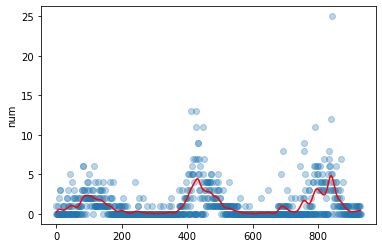

In [28]:
import matplotlib.pyplot as plt
plt.scatter(x,y,alpha=0.3)
plt.plot(x_p,y_p,c='r')
plt.ylabel('num')
plt.show()

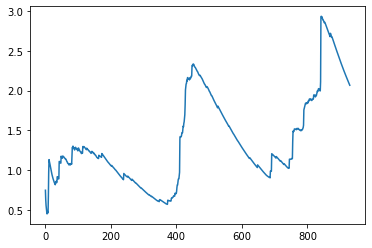

In [21]:
plt.plot(pd.DataFrame({'y':y_p - y}).ewm(com=100).std())

## 3. Empirical mode decomposition

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



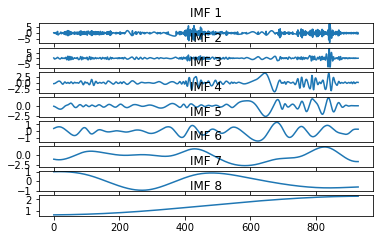

In [26]:
# pip install EMD-signal
from PyEMD import EMD

IMF = EMD().emd(np.array(y),np.array(x))
N = IMF.shape[0]+1

for n, imf in enumerate(IMF):
    plt.subplot(N,1,n+2)
    plt.plot(x, imf)
    plt.title("IMF "+str(n+1))

plt.tight_layout()
plt.show()

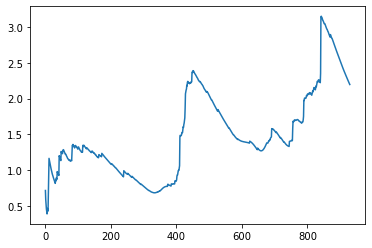

In [22]:
plt.plot(pd.DataFrame({'y':IMF[3]+IMF[2]+IMF[1]+IMF[0]}).ewm(com=100).std())

## 4. Results

- Increasing long-term trend.
- Seasonality.
- Increase in variance of the noise.